In [1]:
import logging
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"

logging.basicConfig(
    level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-08-12 15:46:23,527 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-08-12 15:46:23,528 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-08-12 15:46:24,007 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2024-08-12 15:46:24,014 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2024-08-12 15:46:24,017 - matplotlib - DEBUG - interactive is False
2024-08-12 15:46:24,018 - matplotlib - DEBUG - platform is linux
2024-08-12 15:46:24,091 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2024-08-12 15:46:24,099 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json


# Load data

In [3]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_exp_library_160ms_with_decoy_pred_20240812_150342_222372/config_20240812_150342_222372.yaml"
ps_dir = "exp_20240812_154259_144572"

In [4]:
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)

In [35]:
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)

mobility_values_df = pd.read_csv(os.path.join(cfg.RESULT_PATH, "mobility_values.csv"))
ms1scans = pd.read_csv(os.path.join(cfg.RESULT_PATH, "ms1scans.csv"))

In [6]:
# act_3d = sparse.load_npz(
#     os.path.join(
#         cfg.RESULT_PATH, "results", "activation", "im_rt_pept_act_coo_peptbatch0.npz"
#     )
# )
# hint_matrix = sparse.load_npz(
#     os.path.join(cfg.RESULT_PATH, "results", "activation", "hint_matrix.npz")
# )

In [10]:
import torch
from peak_detection_2d.dataset.dataset import (
    build_transformation,
    MultiHDF5_MaskDataset,
)
from peak_detection_2d.model.build_model import build_model

random_state = cfg.RANDOM_SEED
cfg_peak_selection = cfg.PEAK_SELECTION
hdf5_files = cfg_peak_selection.TRAINING_DATA
transformation, cfg_peak_selection.DATASET = build_transformation(
    cfg_peak_selection.DATASET
)
transformation = None
use_hint_channel = "hint" in cfg_peak_selection.DATASET.INPUT_CHANNELS
logging.info("Use hint channel: %s", use_hint_channel)
dataset = MultiHDF5_MaskDataset(
    hdf5_files,
    use_hint_channel=use_hint_channel,
    transforms=transformation,
)
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_VAL_SIZE,
    seed=random_state,
)
train_dataset, val_dataset = train_val_dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_SIZE,
    seed=random_state,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

2024-08-12 15:49:28,692 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f9156a02ec0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f928c34d8d0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f928c34d5d0>]
2024-08-12 15:49:28,694 - root - INFO - Use hint channel: True


## Sanity check

In [12]:
from pprint import pprint
%matplotlib inline
from peak_detection_2d.utils import plot_data_points

image, hint, label = dataset[45]
to_plot = {
    "data": image[0].cpu(),
    "hint_idx": hint.cpu(),
    "mask": label["mask"][0].cpu(),
    "hint_channel": image[2].cpu(),
}
logging.info("mask sum: %s", label["mask"][0].sum().item())

logging.info("hint channel sum: %s", image[2].sum().item())
plot_data_points(to_plot, zoom_in=False, label="mask", log_data=True)

row = maxquant_result_ref[maxquant_result_ref["mz_rank"] == label["pept_mz_rank"]]
if (True) and (not row["Decoy"].values[0]):
    logging.info("add label")
    pprint(
        row[
            [
                "source",
                "Decoy",
                "mz_rank",
                
                "MS1_frame_idx_left_exp",
                                "MS1_frame_idx_right_exp",
                       "MS1_frame_idx_left_ref",
                "MS1_frame_idx_right_ref",
            ]
        ]
    )
else:
    logging.info("no label since it is decoys")
    pprint(
        row[
            [
                "source",
                "Decoy",
                "mz_rank",

                
                "MS1_frame_idx_left_exp",
                                "MS1_frame_idx_right_exp",
                       "MS1_frame_idx_left_ref",
                "MS1_frame_idx_right_ref",
         
            ]
        ]
    )

2024-08-12 15:49:57,829 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


IndexError: index 2 is out of bounds for dimension 0 with size 1

# Training

In [97]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

## Sanity check

In [121]:
from peak_detection_2d.model.seg_model import UNET

from torchinfo import summary

net = UNET(in_channels=3, first_out_channels=32, exit_channels=1, downhill=7, padding=1)

summary(
    model=net,
    # (batch_size, color_channels, height, width)
    input_size=(8, 3, 258, 258),  # shape =should be (multiple of 2^n_downhill)+2
    col_names=["input_size", "output_size", "num_params"],
    col_width=20,
    row_settings=["var_names"],
    depth=5,
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

## Run model

In [113]:
%autoreload 2
from peak_detection_2d.utils import EarlyStopping
from peak_detection_2d.loss.combo_loss import weighted_dice_metric
from peak_detection_2d.loss.build_criterion import build_criterion
from peak_detection_2d.solver.build_optimizer import build_optimizer, build_scheduler, build_early_stopper
from peak_detection_2d.model.seg_model import train_one_epoch, evaluate, UNET
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from peak_detection_2d.loss.combo_loss import ComboLoss
TRAIN_MODEL = True
EVALUATE = True
EPOCHS = 20
patience = 10
initial_lr = 0.001
model = UNET(3, 32, 1, padding=1, downhill=6).to(device)
# Optimizer, scheduler, amp
cfg_peak_selection = cfg.PEAK_SELECTION
optimizer = build_optimizer(model, cfg_peak_selection.MODEL.SOLVER.OPTIMIZER)
scheduler_type = cfg_peak_selection.MODEL.SOLVER.SCHEDULER.NAME
scheduler = build_scheduler(
    optimizer,
    cfg_peak_selection.MODEL.SOLVER.SCHEDULER,
    steps_per_epoch=int(len(train_dataloader)),
    epochs=cfg_peak_selection.MODEL.SOLVER.TOTAL_EPOCHS,
)
criterion = build_criterion(cfg_peak_selection.MODEL.SOLVER.LOSS)
es = build_early_stopper(cfg_peak_selection.MODEL.SOLVER.EARLY_STOPPING)
train_loss = []
metric = {"train":[], "val":[]}
result_dir = cfg.RESULT_PATH
ps_dir = os.path.join(result_dir, "peak_selection")

if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion, use_image_as_input=True, device = device, scheduler=scheduler)
        train_metric = evaluate(train_dataloader, model, metric=weighted_dice_metric, use_image_for_metric=True, device=device)
        val_metric = evaluate(val_dataloader, model, metric=weighted_dice_metric, use_image_for_metric=True, device = device)
        metric["train"].append(train_metric)
        metric["val"].append(val_metric)
        train_loss.append(loss)
        #scheduler.step(val_metric)
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, TRAIN DICE: {train_metric}, VAL DICE: {val_metric}")
        es(
            val_metric,
            model,
            model_path=os.path.join(
                cfg.RESULT_PATH, peak_data_dir, f"bst_model_{np.round(val_metric,4)}.bin"
            ),
        )
        best_model = os.path.join(
            result_dir, peak_data_dir, f"bst_model_{np.round(es.best_score,4)}.bin"
        )
        if es.early_stop:
            print("\n\n -------------- EARLY STOPPING -------------- \n\n")
            break


  0%|          | 0/3536 [00:00<?, ?it/s]/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  9%|▊         | 303/3536 [03:59<42:37,  1.26it/s, learning_rate=0.0004, loss=3.54]


KeyboardInterrupt: 

In [36]:
%autoreload 2
from peak_detection_2d.utils import EarlyStopping
from peak_detection_2d.loss.combo_loss import weighted_dice_metric, WeightedDiceLoss
from peak_detection_2d.model.seg_model import train_one_epoch, evaluate, UNET
from torch.optim.lr_scheduler import ReduceLROnPlateau
from peak_detection_2d.loss.combo_loss import ComboLoss
TRAIN_MODEL = True
EVALUATE = True
EPOCHS = 20
patience = 10
initial_lr = 0.001
model = UNET(1, 32, 1, padding=1, downhill=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.1, patience=3, min_lr=0.000001
)
#criterion = nn.BCEWithLogitsLoss()
criterion = WeightedDiceLoss(per_image=True)
es = EarlyStopping(patience=patience, mode="max")
train_loss = []
metric = {"train":[], "val":[]}
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion, use_image_as_input=True)
        train_metric = evaluate(train_dataloader, model, metric=weighted_dice_metric, use_image_for_metric=True, device=device)
        val_metric = evaluate(val_dataloader, model, metric=weighted_dice_metric, use_image_for_metric=True, device = device)
        metric["train"].append(train_metric)
        metric["val"].append(val_metric)
        train_loss.append(loss)
        #scheduler.step(val_metric)
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, TRAIN DICE: {train_metric}, VAL DICE: {val_metric}")
        es(
            epoch_score = val_metric,
            epoch_num = epoch,
            model = model,
            model_path=os.path.join(
                result_dir, peak_data_dir, f"bst_model_{np.round(val_metric,4)}.bin"
            ),
            loss=loss,
            optimizer=optimizer,
            scheduler = scheduler

        )
        best_model = os.path.join(
            result_dir, peak_data_dir, f"bst_model_{np.round(es.best_score,4)}.bin"
        )
        if es.early_stop:
            print("\n\n -------------- EARLY STOPPING -------------- \n\n")
            break


  0%|          | 0/224 [00:00<?, ?it/s]2024-06-12 13:57:30,856 - peak_detection_2d.loss.combo_loss - INFO - weighted_intersection tensor([11096.1084,  6806.0957,  9097.3740, 10651.0449, 29698.0762, 22523.7070,
        24359.6895, 26890.6387, 86160.7188,  2915.3804, 11837.5859, 26876.9531,
         6859.4067, 10102.6113,  8304.9980,  8610.7070], device='cuda:0',
       grad_fn=<SumBackward1>)
2024-06-12 13:57:30,859 - peak_detection_2d.loss.combo_loss - INFO - weighted_union tensor([ 60495.9609,  79111.5938, 112315.0312, 116612.4766, 253321.6719,
        197605.2812, 362048.6562,  96665.3047, 323429.1250, 203766.1406,
         82807.3438, 120216.0469,  47137.6719,  94333.0703,  52660.8984,
         44831.4570], device='cuda:0', grad_fn=<AddBackward0>)
  0%|          | 1/224 [00:00<01:38,  2.27it/s, learning_rate=0.001, loss=0.716]2024-06-12 13:57:31,291 - peak_detection_2d.loss.combo_loss - INFO - weighted_intersection tensor([   2891.8823,   57501.5234,   89406.1328,    3954.9578,   13

EPOCH: 0, TRAIN LOSS: 0.4446053049261017, TRAIN DICE: 0.6303033277924571, VAL DICE: 0.6938755512237549


TypeError: EarlyStopping.__call__() missing 3 required positional arguments: 'loss', 'optimizer', and 'model'

## Evaluation

In [48]:
%autoreload 2
from peak_detection_2d.loss.custom_loss import per_image_weighted_dice_metric

val_metric = evaluate(
    val_dataloader,
    model,
    metric=per_image_weighted_dice_metric,
    use_image_for_metric=True,
    device=device,
    channel=0,
    threshold=None,
)

100%|██████████| 4/4 [00:04<00:00,  1.05s/it, loss=0.561]


In [51]:
%autoreload 2
val_metric = evaluate(
    val_dataloader,
    model,
    metric=weighted_dice_metric,
    use_image_for_metric=True,
    device=device,
    #threshold=0.5,
    per_image=True,
    # channel=0,
    threshold=None,
)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:04<00:00,  1.04s/it, loss=0.561]


In [ ]:
plot_sample_predictions(
    test_dataset,
    model=normal_model,
    sample_indices=[testset_idx],
    # n = 10,
    save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    # save_dir=os.path.join(log_trans_dir, "sample_predictions_highest_wiou"),
)

In [28]:
%autoreload 2
from peak_detection_2d.utils import plot_sample_predictions
from peak_detection_2d.loss import per_image_weighted_iou_metric
bst_model = UNET(2, 32, 1, padding=1, downhill=4).to(device)
checkpoint=torch.load(best_model, map_location=device)
bst_model.load_state_dict(checkpoint)
ind_avg_wiou, ind_all_wiou_log = evaluate(
    model=bst_model,
    valid_loader=test_dataloader,
    device=device,
    metric=per_image_weighted_iou_metric,
    save_all_loss=True,
    use_image_for_metric=True,
    channel = 0
)
ind_all_wiou_df = pd.DataFrame(ind_all_wiou_log)

<All keys matched successfully>

100%|██████████| 4/4 [00:02<00:00,  1.36it/s, loss=0.63] 


25%: 0.31
50%: 0.80
75%: 0.94


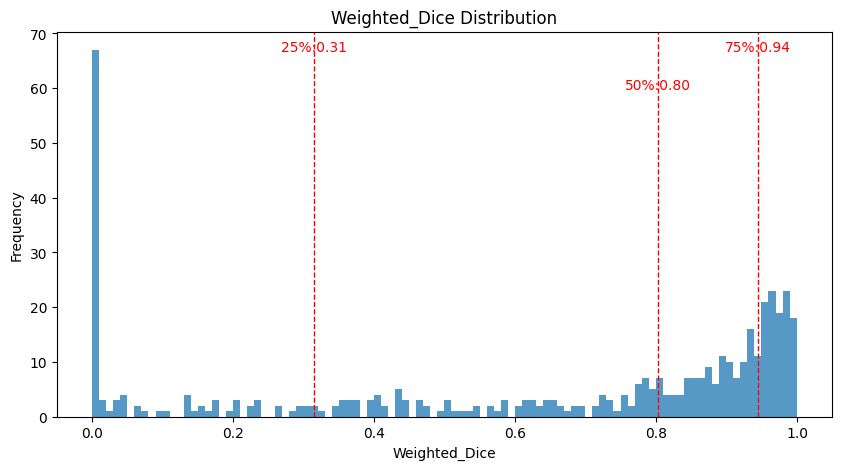

In [27]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(ind_all_wiou_log["losses"], "Weighted_IoU", save_dir=None)

In [44]:
np.array([0, 2, 2]) > 1

array([False,  True,  True])

2024-06-05 14:05:08,158 - peak_detection_2d.loss - INFO - dice loss shape: torch.Size([1])


2024-06-05 14:05:08,175 - peak_detection_2d.utils - INFO - Masked area tensor(616., dtype=torch.float64)
2024-06-05 14:05:08,177 - peak_detection_2d.utils - INFO - Masked intensity sum 1720.552039738694
2024-06-05 14:05:08,178 - peak_detection_2d.utils - INFO - Pred masked inensity sum 1196.6518524089975


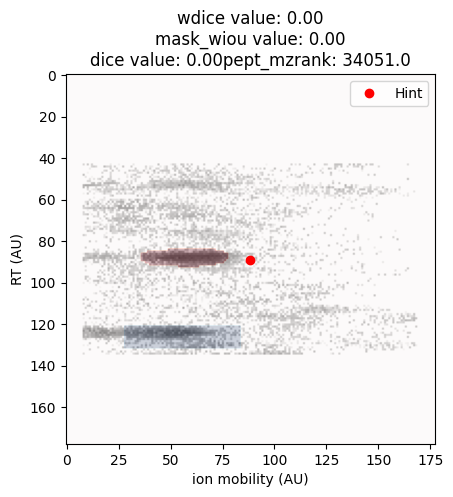

In [62]:
testset_idx = ind_all_wiou_df.loc[ind_all_wiou_df["ranks"] == 34051].index[0]
plot_sample_predictions(
    test_dataset,
    model=bst_model,
    # n=5,
    sample_indices=[testset_idx],
    metric_list=["wdice", "mask_wiou", "dice"],
    use_hint=False,
    save_dir=None,
    zoom_in=False,
    label="mask",
    channel=1,
    # save_dir=os.path.join(result_dir, peak_data_dir, "sample_predictions"),
)

In [99]:
%autoreload 2
if EVALUATE:
    test_score = evaluate(test_dataloader, model, metric=weighted_dice_loss)
    print(f"Valid dice score: {test_score}")

  0%|          | 0/33 [00:00<?, ?it/s]

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.63 GiB. GPU  (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 3.19 GiB. GPU  (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 0/33 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.89 GiB. GPU 

In [9]:
%autoreload 2
from peak_detection_2d.loss import WeightedBoundingBoxIoULoss
import logging
import json
import os

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from peak_detection_2d.utils import (
    plot_sample_predictions,
    plot_history,
)
from peak_detection_2d.dataset import MultiHDF5Dataset, ToTensor, Padding
from peak_detection_2d.model.seg_model import (
    UNET,
    train_val_step,
    train_one_epoch)
num_epoch = 1
patience = 10
inital_lr = 0.001
batch_size = 4

random_state = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()
model = UNET(1, 16, 1, padding=1, downhill=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=inital_lr)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3, min_lr=0.000001
)

loss_tracking = {"train": [], "val": []}
iou_tracking = {"train": [], "val": []}
best_loss = float("inf")
for epoch in range(num_epoch):
    logging.info("Epoch %d/%d", epoch + 1, num_epoch)

    training_loss, trainig_iou = train_one_epoch(
        train_dataloader, model, loss_fn, optimizer
    )
    loss_tracking["train"].append(training_loss)
    iou_tracking["train"].append(trainig_iou)

    with torch.inference_mode():
        val_loss, val_iou = train_val_step(val_dataloader, model, loss_fn, None)
        loss_tracking["val"].append(val_loss)
        iou_tracking["val"].append(vala_iou)
        if val_loss < best_loss:
            logging.info("Saving best model")
            torch.save(
                model.state_dict(), os.path.join(result_dir, peak_data_dir, "best_model.pt")
            )
            best_loss = val_loss
            current_patience = patience
        else:
            current_patience -= 1
            if current_patience == 0:
                logging.info("Early stopping")
                break
        scheduler.step(val_loss)
        logging.info(
            "Last learning rate: %s",
            scheduler.get_last_lr(),
        )

    logging.info("Training loss: %.6f, IoU: %.2f", training_loss, trainig_iou)
    logging.info("Validation loss: %.6f, IoU: %.6f", val_loss, val_iou)

2024-05-31 09:30:22,032 - root - INFO - Epoch 1/1


IndexError: index 2 is out of bounds for dimension 1 with size 1

In [39]:
plot_sample_predictions(
    test_dataset,
    model=model,
    n=10,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions"),
)

NameError: name 'peak_selection_dir' is not defined

In [7]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from peak_detection_2d.utils import plot_data_points

# Sample n datapoints from test_dataset
n = 5
sample_indices = np.random.choice(len(test_dataset), n, replace=False)
for i in sample_indices:
    image, hint, label = test_dataset[i]
    output = model(image.unsqueeze(0).float(), hint.unsqueeze(0).float())
    iou = iou_batch(output, label.unsqueeze(0))
    to_plot = {"data": image[0].cpu(), "hint_idx": hint.cpu(), "bbox": label.cpu()}
    plot_data_points(to_plot, pred_bbox=output[0].cpu().detach().numpy(), zoom_in=True)
    plt.title(f"IoU: {iou:.2f}")
    plt.savefig(f"sample_{i}.png", dpi=300)
    plt.close()

# Predict on unprocessed sparse matrix

In [15]:
# prepare data
import sparse

swaps_dir = "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_120min_library_80ms_with_decoy_pred_20240806_090347_182738/"

exp_dir = os.path.join(swaps_dir, "peak_selection", "exp_20240808_210454_905643")

act_3d = sparse.load_npz(
    os.path.join(
        swaps_dir, "results", "activation", "im_rt_pept_act_coo_peptbatch0.npz"
    )
)
hint_matrix = sparse.load_npz(
    os.path.join(swaps_dir, "peak_selection", "training_data/hint_matrix.npz")
)

In [16]:
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

ps_config_path = os.path.join(exp_dir, "updated_peak_selection_config.yaml")
cfg_peak_selection = get_cfg_defaults(swaps_optimization_cfg.PEAK_SELECTION)
cfg_peak_selection.merge_from_file(ps_config_path)

In [17]:
pept_batch_size = act_3d.shape[2] // 4
maxquant_result_ref["pept_batch_idx"] = (
    maxquant_result_ref["mz_rank"] // pept_batch_size
).astype(int)
max_pept_batch_idx = maxquant_result_ref["pept_batch_idx"].max()
maxquant_result_ref.loc[
    maxquant_result_ref["pept_batch_idx"] == max_pept_batch_idx, "pept_batch_idx"
] = (max_pept_batch_idx - 1)

In [18]:
batch0_maxquant_ref = maxquant_result_ref.loc[
    maxquant_result_ref["pept_batch_idx"] == 0
]
sample_batch0_maxquant_ref = batch0_maxquant_ref.sample(n=4000, replace=False)

In [19]:
%autoreload 2
from peak_detection_2d.dataset.dataset import (
    PeptActPeakSelection_Infer_Dataset,
    build_transformation,
)
from peak_detection_2d.model.build_model import build_model
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_model(cfg_peak_selection.MODEL)
checkpoint = torch.load(
    os.path.join(exp_dir, "model_backups", "bst_model_0.5104.pt"), map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
transformation, _ = build_transformation(cfg_peak_selection.DATASET)
infer_dataset = PeptActPeakSelection_Infer_Dataset(
    pept_act_coo_peptbatch=act_3d,
    maxquant_dict=sample_batch0_maxquant_ref,
    hint_matrix=hint_matrix,
    transforms=transformation,
    use_hint_channel=True,
)
# feed into modle
# generate a pept_act_sun.csv

<All keys matched successfully>

2024-08-09 09:44:44,922 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f7bdac78520>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f7a974ae2c0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f7a974ace50>]


In [20]:
torch.cuda.empty_cache()
import gc

gc.collect()

31

In [21]:
# Example usage
infer_dataset = PeptActPeakSelection_Infer_Dataset(
    pept_act_coo_peptbatch=act_3d,
    maxquant_dict=sample_batch0_maxquant_ref,
    hint_matrix=hint_matrix,
    transforms=transformation,
    use_hint_channel=True,
)
infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset, batch_size=32, shuffle=False
)
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

result = inference_and_sum_intensity(
    model=model, data_loader=infer_dataloader, device=device, calc_score=True
)

2024-08-09 09:44:55,258 - numba.core.entrypoints - DEBUG - Loading extension: EntryPoint(name='init', value='sparse._numba_extension:_init_extension', group='numba_extensions')
2024-08-09 09:44:55,506 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=398)
           2	LOAD_GLOBAL(arg=0, lineno=455)
           4	LOAD_ATTR(arg=1, lineno=455)
           6	LOAD_ATTR(arg=2, lineno=455)
           8	LOAD_METHOD(arg=3, lineno=455)
          10	LOAD_GLOBAL(arg=0, lineno=455)
          12	LOAD_ATTR(arg=4, lineno=455)
          14	LOAD_ATTR(arg=5, lineno=455)
          16	CALL_METHOD(arg=1, lineno=455)
          18	STORE_FAST(arg=2, lineno=455)
          20	LOAD_FAST(arg=2, lineno=456)
          22	LOAD_METHOD(arg=6, lineno=456)
          24	LOAD_CONST(arg=1, lineno=456)
          26	CALL_METHOD(arg=1, lineno=456)
          28	POP_TOP(arg=None, lineno=456)
          30	LOAD_GLOBAL(arg=0, lineno=457)
          32	LOAD_ATTR(arg=1, lineno=457)
          34	LOAD_ATTR(a

In [22]:
infer_result = pd.merge(
    result,
    maxquant_result_ref,
    how="left",
    left_on="mz_rank",
    right_on="mz_rank",
    suffixes=("_ref", "_pred"),
)

In [30]:
decoy_mzbin = maxquant_result_ref.loc[maxquant_result_ref["Decoy"], "mz_bin"].unique()
random_sample = np.random.choice(decoy_mzbin, size=10, replace=False)

In [31]:
in_mz_bins = maxquant_result_ref.loc[maxquant_result_ref["mz_bin"].isin(random_sample)]

In [37]:
in_mz_bins[["mz_bin", "Decoy"]].value_counts()

mz_bin   Decoy
977.01   True     5
969.84   True     3
977.01   False    3
1063.20  True     2
1213.13  True     2
751.61   False    1
         True     1
792.08   True     1
817.80   True     1
891.69   False    1
         True     1
1072.58  True     1
1162.55  True     1
1213.13  False    1
dtype: int64

In [23]:
infer_result["Decoy"].value_counts()

True     2375
False    1624
Name: Decoy, dtype: int64

<Axes: xlabel='log_sum_intensity', ylabel='Density'>

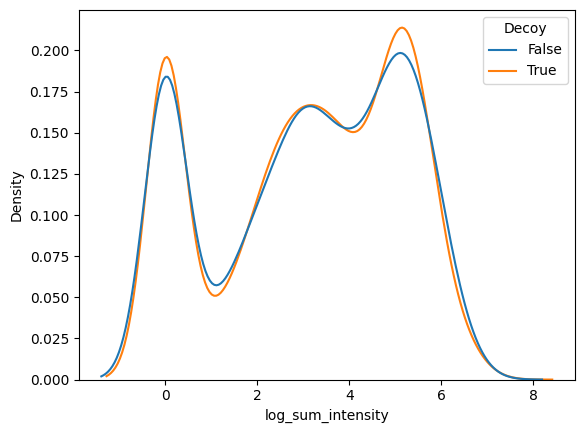

In [25]:
import seaborn as sns

infer_result["log_sum_intensity"] = np.log10(infer_result["sum_intensity"] + 1)
sns.kdeplot(data=infer_result, x="log_sum_intensity", hue="Decoy", common_norm=False)

In [66]:
dp_dict = infer_dataset[286]

In [69]:
output = model(
    dp_dict[0].float().unsqueeze(0).to(device),
)

tensor(0., dtype=torch.float64)

tensor(4., device='cuda:0', dtype=torch.float64)

2024-08-09 10:16:45,749 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


119

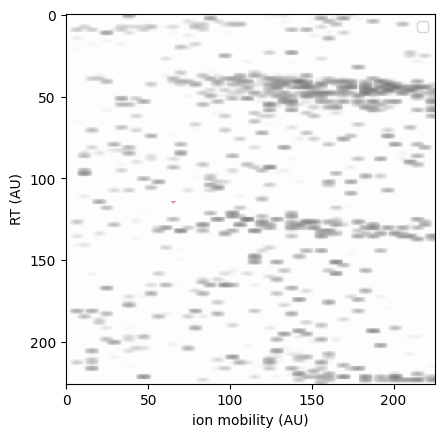

In [41]:
from peak_detection_2d.utils import plot_data_points

image, hint, label = infer_dataset[119]
to_plot = {
    "data": image[0].cpu(),
    "hint_idx": hint.cpu(),
    "mask": label["mask"][0].cpu(),
    "hint_channel": image[2].cpu(),
}
label["mask"][0].sum()
image[2].sum()
plot_data_points(
    to_plot,
    zoom_in=False,
    label="mask",
    log_data=True,
    # pred_mask=output[0].cpu().detach().numpy()[0],
)
label["pept_mz_rank"]

In [79]:
image[2].sum()

tensor(1., device='cuda:0', dtype=torch.float64)

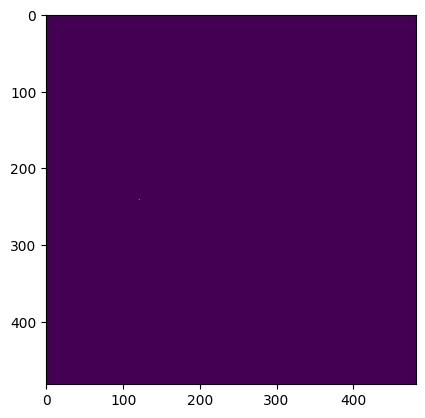

In [78]:
plt.imshow(image[2].cpu())

In [28]:
# Example usage

infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset, batch_size=32, shuffle=False
)
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

result = inference_and_sum_intensity(
    model=model, data_loader=infer_dataloader, device=device
)

2024-08-08 11:35:23,385 - peak_detection_2d.dataset.dataset - WARNING - No maxquant result found for peptide mz rank 0
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 5.93 GiB. GPU  (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
2024-08-08 11:35:27,189 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 481
2024-08-08 11:35:27,191 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (32,)
2024-08-08 11:35:27,195 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (32,)
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 2.97 GiB. GPU  (Trigg

SystemError: CPUDispatcher(<function _compute_mask at 0x7f454cacc1f0>) returned a result with an exception set

## Eval on test

In [31]:
from peak_detection_2d.train import testset_eval
from peak_detection_2d.dataset.dataset import (
    MultiHDF5_MaskDataset,
    build_transformation,
)

hdf5_files = cfg_peak_selection.TRAINING_DATA
transformation, _ = build_transformation(cfg_peak_selection.DATASET)
use_hint_channel = "hint" in cfg_peak_selection.DATASET.INPUT_CHANNELS
dataset = MultiHDF5_MaskDataset(
    hdf5_files,
    use_hint_channel=use_hint_channel,
    transforms=transformation,
)
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_VAL_SIZE,
    seed=42,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

2024-08-08 11:49:42.209855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 11:49:52,178 - tensorflow - DEBUG - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2024-08-08 11:49:53.659302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-08 11:50:10,701 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Padding object at 0x7f44712d52a0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f44712d6aa0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f44712d6980>]


In [35]:
%autoreload 2
from result_analysis.result_analysis import SBSResult
import pandas as pd
try:
    test_pred_df = pd.read_csv(
        os.path.join(exp_dir, "results", "test_pred_df.csv")
    )
except FileNotFoundError:
    test_pred_df = inference_and_sum_intensity(
        data_loader=test_dataloader,
        model=model,
        device=device,
        calc_score = True,
        # calc_score="sigmoid",
        # plot_calib_score_distribution=True,
        # result_dir=os.path.join(exp_dir, "results"),
    )
    test_pred_df.to_csv(
        os.path.join(exp_dir, "results", "test_pred_df.csv"), index=False
    )
# maxquant_merge = pd.read_pickle(
#     os.path.join(result_dir, "maxquant_result_ref.pkl")
# )


2024-08-08 12:23:43,328 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 481
2024-08-08 12:23:43,330 - peak_detection_2d.model.seg_model - DEBUG - valid_pixel shape torch.Size([32, 232324])
2024-08-08 12:23:43,355 - peak_detection_2d.model.seg_model - DEBUG - out_score shape (32,)
2024-08-08 12:23:43,357 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (32,)
2024-08-08 12:23:43,360 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (32,)
2024-08-08 12:23:44,457 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 481
2024-08-08 12:23:44,459 - peak_detection_2d.model.seg_model - DEBUG - valid_pixel shape torch.Size([32, 232324])
2024-08-08 12:23:44,461 - peak_detection_2d.model.seg_model - DEBUG - out_score shape (64,)
2024-08-08 12:23:44,462 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (64,)
2024-08-08 12:23:44,466 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity 

TypeError: SBSResult.__init__() got an unexpected keyword argument 'sum_raw'

In [38]:
test_pred_df.rename(columns={"pept_mz_rank": "mz_rank"}, inplace=True)

2024-08-08 12:30:05,411 - result_analysis.result_analysis - DEBUG - Pept activation sum columns: Index(['sum_intensity', 'mz_rank', 'out_score'], dtype='object')
2024-08-08 12:30:05,415 - result_analysis.result_analysis - INFO - Reference shape: (179460, 119)
2024-08-08 12:30:05,510 - result_analysis.result_analysis - DEBUG - Reference shape after merging activation sum: (3458, 121)
2024-08-08 12:30:05,511 - result_analysis.result_analysis - DEBUG - Ref df mz_rank columns: (3458,)
2024-08-08 12:30:05,518 - result_analysis.result_analysis - DEBUG - sum cols: ['sum_intensity', 'mz_rank', 'out_score']
2024-08-08 12:30:05,518 - result_analysis.result_analysis - DEBUG - Reference non zero shape: (3418, 121)
2024-08-08 12:30:05,521 - result_analysis.result_analysis - INFO - No grouping, show precurosr level correlation
2024-08-08 12:30:05,521 - result_analysis.result_analysis - DEBUG - Ref exp inner shape (3458, 121)


Data:  Intensity_log sum_intensity_log , slope =  0.978 , intercept =  -0.497 , PearsonR =  0.756 , SpearmanR =  0.812


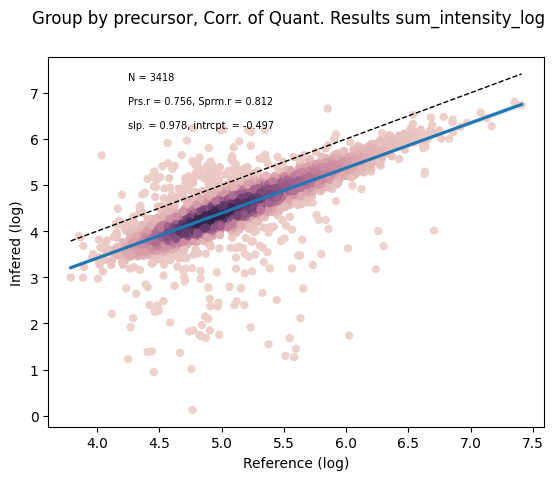

In [40]:
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_merge_df=maxquant_result_ref,
    pept_act_sum_df_list=[test_pred_df],
    # sum_raw=test_pred_df,
    # sum_gaussian=train_label_df,
    ims=True,
    # other_cols=other_cols
)
sbs_ims_result.plot_intensity_corr(
    ref_col="Intensity",
    inf_col="sum_intensity",
    contour=False,
    # group_by="Leading razor protein",
    # save_dir=os.path.join(peak_selection_dir, "results"),
)

In [ ]:
testset_eval(
    best_model_path="/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_120min_library_80ms_with_decoy_pred_20240806_090347_182738/peak_selection/exp_20240807_145220_847593/model_backups/bst_model_0.7929.pt",
    cfg_model=cfg_peak_selection.MODEL,
    test_dataset=test_dataset,
    test_dataloader=test_dataloader,
    result_dir=exp_dir,
    device=device,
    exp=cfg_peak_selection.DATASET.ONLY_LOG_CHANNEL,
    threshold=cfg_peak_selection.MODEL.EVALUATION.THRESHOLD,
)

In [55]:
pept_batch_size = act_3d.shape[2] // 4
maxquant_result_ref["pept_batch_idx"] = (
    maxquant_result_ref["mz_rank"] // pept_batch_size
).astype(int)
max_min_mz_rank = maxquant_result_ref.groupby("pept_batch_idx")["mz_rank"].agg(
    ["min", "max"]
)
cutoff = [0]
cutoff.extend(max_min_mz_rank["min"].values[1:-1].tolist())
cutoff.append(max_min_mz_rank["max"].values[-1] + 1)
cutoff

[0, 44865, 89730, 134595, 179461]

In [39]:
%autoreload 2
from peak_detection_2d.dataset.dataset import (
    PeptActPeakSelection_Infer_Dataset,
    build_transformation,
)
from peak_detection_2d.model.build_model import build_model
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_model(cfg_peak_selection.MODEL)
checkpoint = torch.load(
    os.path.join(exp_dir, "model_backups", "bst_model_0.7929.pt"), map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
transformation, _ = build_transformation(cfg_peak_selection.DATASET)
infer_dataset = PeptActPeakSelection_Infer_Dataset(
    pept_act_coo_peptbatch=act_3d,
    maxquant_dict=maxquant_result_ref.loc[maxquant_result_ref["pept_batch_idx"] == 0],
    hint_matrix=hint_matrix,
    transforms=transformation,
    use_hint_channel=True,
)
# feed into modle
# generate a pept_act_sun.csv

<All keys matched successfully>

2024-08-07 15:12:56,453 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f8a49d6f7c0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f8a43d9bbb0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f8a43d99de0>]
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/dataset/dataset.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxquant_dict[


In [40]:
# Example usage

infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset, batch_size=16, shuffle=False
)
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

result = inference_and_sum_intensity(
    model=model, data_loader=infer_dataloader, device=device
)

2024-08-07 15:13:08,944 - peak_detection_2d.dataset.dataset - WARNING - No maxquant result found for peptide mz rank 0
2024-08-07 15:13:10,762 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 193
2024-08-07 15:13:10,764 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (16,)
2024-08-07 15:13:10,765 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (16,)
2024-08-07 15:13:11,492 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 193
2024-08-07 15:13:11,493 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (32,)
2024-08-07 15:13:11,494 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (32,)
2024-08-07 15:13:12,245 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 193
2024-08-07 15:13:12,247 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (48,)
2024-08-07 15:13:12,248 - peak_detection_2d.model.seg_model - DEBUG - sum_

SystemError: CPUDispatcher(<function _compute_mask at 0x7f8d76db9f30>) returned a result with an exception set